In [12]:
import pandas as pd

In [13]:
#import annotated data
df = pd.read_csv('annotated_tweets.csv', engine='python')
df = df.drop('Unnamed: 0', axis=1)
df.at[2042, 'status'] = 1
df.at[2001, 'status'] = 0
df.at[2110, 'status'] = 0
df = df.dropna(subset=['status'])
df = df.drop_duplicates()
print(len(df))
display(df.tail())

4341


,created_at,id,text,user_id,user_location,status
4563,Tue Oct 06 10:29:26 +0000 2009,4652197012,@nbczoraida no flu shot- I'm too worried for t...,11047142.0,Chicago & traveling the world,1.0
4564,Mon Oct 05 11:18:04 +0000 2009,4625766602,"Getting my flu (influenza only) shot today, so...",15321133.0,"Tallahassee, FL",1.0
4565,Thu Sep 03 22:15:07 +0000 2009,3743344807,Fuck! I feel like I'm not getting any better.....,22867290.0,NaN,1.0
4566,Thu Sep 03 13:17:11 +0000 2009,3733228912,im planning on getting a flu shot today... you...,25675148.0,"Los Angeles, CA",1.0
4567,Sat Oct 03 18:25:15 +0000 2009,4584372810,To Flu Vacc or not to Flu Vacc. the kids?Is th...,47384671.0,"San Leandro, California",1.0


In [14]:
pos = df[df['status']==1.0]
neg = df[df['status']==0.0]

In [15]:
from nltk.corpus import stopwords
import numpy as np
import string 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC

# Natural Language Processing

In [16]:
def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

data = df['text']
labels = df['status']
train_data, test_data, y_train, y_test = train_test_split(data, labels)

vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenize)

x_train = vectorizer.fit_transform(train_data)
x_test = vectorizer.transform(test_data)

In [18]:
dftrain = pd.DataFrame(x_train.toarray())
dftrain.columns = vectorizer.get_feature_names()
dftrain.head()

,!,"""",#,##forewarning,#11,#13aban,#140tc,#24,#24hourz,#82,...,☺,♥,保持好心情最重要哦,加油加油,我们一起战胜flu,,,,！,，
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.278095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

## Descriptive Visualizations

No handles with labels found to put in legend.


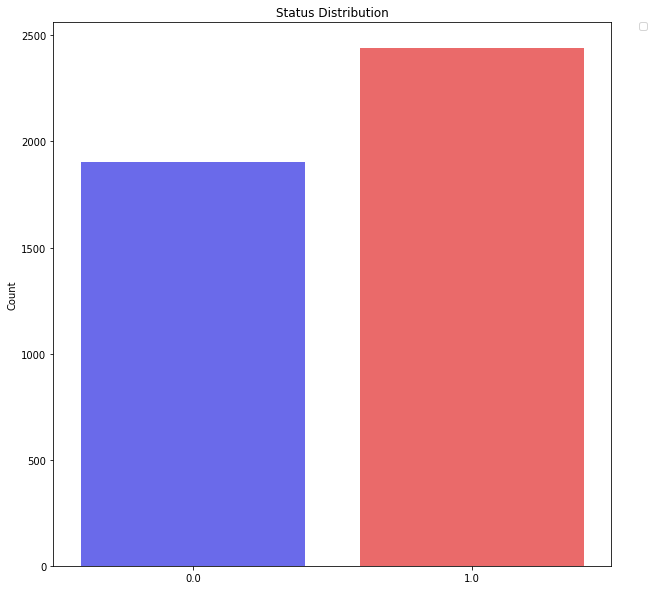

In [19]:
#distribution of annotated dataset (0/1)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(x="status", data=df, palette='seismic')
ax.set_title('Status Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Linear Regression

In [9]:
#This will assess correlation between outbreak predicted by twitter data 

# Dimensionality Reduction: Principle Component Analysis (PCA)

# Machine Learning Classification Algorithms

## Naive Bayes

In [20]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
preds = nb.predict(x_test)
y_score = nb.predict_proba(x_test)

### Metrics

Accuracy Score for model: 72.38%
Precision Score for model: 68.61%
Recall Score for model: 92.17%
F1 Score for model: 78.66%


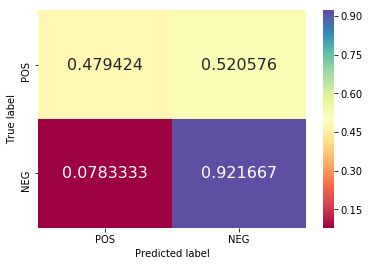

AUC: 0.8134156378600823


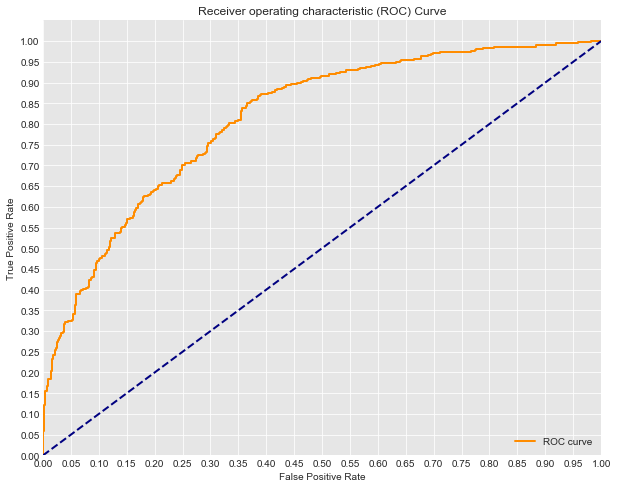

In [21]:
def print_metrics(model, x_test, y_test):
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print("Accuracy Score for model: {:.4}%".format(accuracy * 100))
    print("Precision Score for model: {:.4}%".format(precision * 100))
    print("Recall Score for model: {:.4}%".format(recall * 100))
    print("F1 Score for model: {:.4}%".format(f1 * 100))
    return accuracy, precision, recall, f1
    

def cm_plot(labels, predictions, normalize=False, cmap='Spectral'):
    cm = confusion_matrix(labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, ['POS', 'NEG'], ['POS', 'NEG'])
    sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap=cmap)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.colorbar()
    plt.show()

def plot_roc_curve(labels, predictions, y_score):
    fpr, tpr, thresholds = roc_curve(labels, y_score)
    print('AUC: {}'.format(auc(fpr, tpr)))
    #Seaborns Beautiful Styling
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

nb_accuracy, nb_precision, nb_recall, nb_f1 = print_metrics(nb,x_test,y_test)
cm_plot(y_test,preds, normalize=True, cmap='Spectral')
plot_roc_curve(y_test,preds, y_score[:,1])

## Logistic Regression

In [23]:
log = LogisticRegression()
log = log.fit(x_train, y_train)
preds = log.predict(x_test)
y_score = log.decision_function(x_test)

### Metrics

Accuracy Score for model: 74.86%
Precision Score for model: 73.87%
Recall Score for model: 84.33%
F1 Score for model: 78.75%


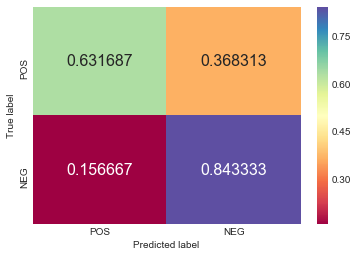

AUC: 0.8229492455418381


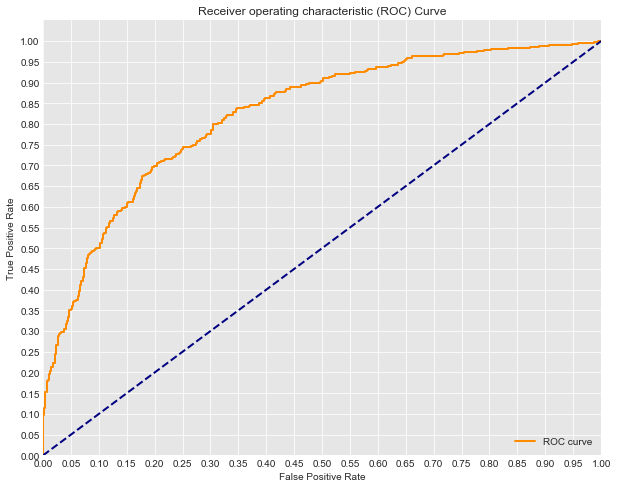

In [24]:
log_accuracy, log_precision, log_recall, log_f1 = print_metrics(log,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
plot_roc_curve(y_test,preds,y_score)

### Hyperparameter Tuning

**L1 vs. L2 Regularization**

AUC for l1: 0.8117729766803842
AUC for l2: 0.822071330589849


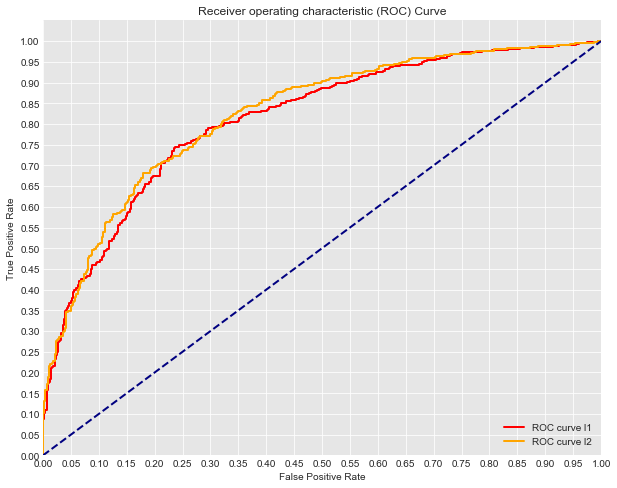

In [25]:
#compare L1 & L2 regularization
penalties = ['l1', 'l2']
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

for n, pen in enumerate(penalties):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, penalty=pen) #Starter code
    model_log = logreg.fit(x_train, y_train)
    #Predict
    y_hat_test = logreg.predict(x_test)
    y_score = logreg.fit(x_train, y_train).decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(str(pen), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Balanced Class Weights**

AUC for balanced: 0.8203737997256516
AUC for None: 0.822071330589849


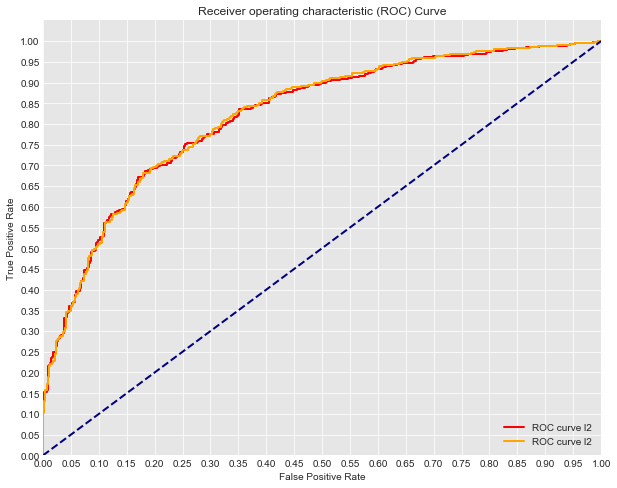

In [26]:
#compare L1 & L2 regularization
wgts = ['balanced', None]
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

for n, wgt in enumerate(wgts):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, class_weight=wgt) #Starter code
    model_log = logreg.fit(x_train, y_train)
    #Predict
    y_hat_test = logreg.predict(x_test)
    y_score = logreg.fit(x_train, y_train).decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(str(wgt), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [27]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(x_train, y_train)
preds = forest.predict(x_test)
y_score = forest.predict_proba(x_test)

### Metrics

Accuracy Score for model: 58.47%
Precision Score for model: 57.12%
Recall Score for model: 99.67%
F1 Score for model: 72.62%


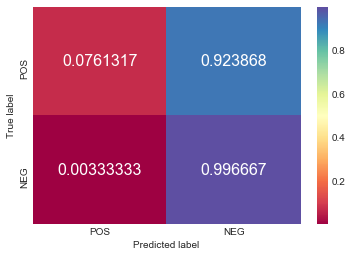

In [28]:
print_metrics(forest,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
# roc_curve(y_test,preds,y_score[:,1])

### Hyperparameter Tuning

In [18]:
#adjust n_estimators

## Gradient Boosting

In [29]:
#adjust learning rate
gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01)
gradboost.fit(x_train, y_train)
preds = gradboost.predict(x_test)

### Metrics

Accuracy Score for model: 66.02%
Precision Score for model: 64.35%
Recall Score for model: 86.33%
F1 Score for model: 73.74%


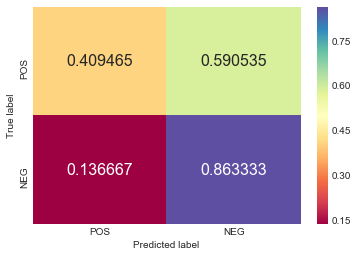

In [30]:
gb_accuracy, gb_precision, gb_recall, gb_f1 = print_metrics(gradboost,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
# roc_curve(y_test,preds,y_score[:,1])

## AdaBoost

In [31]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(x_train, y_train)
preds = adaboost.predict(x_test)

### Metrics

Accuracy Score for model: 72.74%
Precision Score for model: 72.29%
Recall Score for model: 82.17%
F1 Score for model: 76.91%


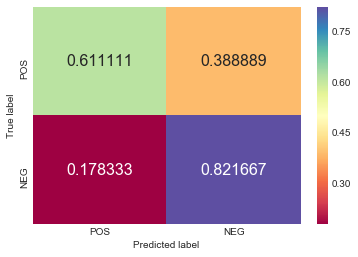

In [32]:
ada_accuracy, ada_precision, ada_recall, ada_f1 = print_metrics(adaboost,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
# roc_curve(y_test,preds,y_score[:,1])

## Support Vector Machine

In [33]:
svm = SVC(kernel='linear')
svm = svm.fit(x_train, y_train) 
preds = svm.predict(x_test)

In [34]:
#visualization
#https://github.com/learn-co-students/ds-support-vector-machines-lab-nyc-career-ds-062518/tree/solution

### Metrics

Accuracy Score for model: 72.84%
Precision Score for model: 72.86%
Recall Score for model: 81.0%
F1 Score for model: 76.72%


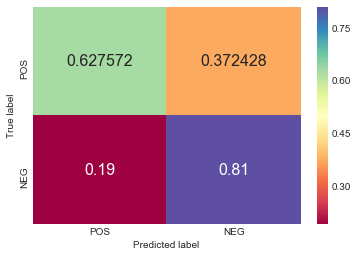

In [35]:
svm_accuracy, svm_precision, svm_recall, svm_f1 = print_metrics(svm,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
# roc_curve(y_test,preds, y_score)

# Feed-Forward Neural Net: Multi-Layer Perceptron 

In [128]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.models import model_from_json
from sklearn.externals import joblib
from keras import regularizers

### Hyperparameters

In [137]:
epochs=25
optimizer = optimizers.Adam(lr=0.00003, decay=0.0001)
# optimizer = optimizers.SGD(lr=0.003, decay=0.0001, momentum=0.9)
batch_size=32
loss='binary_crossentropy'
activation='relu'
out_activation='sigmoid'

In [138]:
tbcallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size, 
                                         write_graph=True, write_images=True)

### Model - Adam

In [139]:
model = Sequential()
model.add(Dense(150, input_dim=len(vectorizer.get_feature_names()), kernel_regularizer=regularizers.l1(0.005), activation=activation))
model.add(Dropout(0.3))
model.add(Dense(75, kernel_regularizer=regularizers.l1(0.005), activation=activation))
model.add(Dropout(0.3))
model.add(Dense(1, activation=out_activation))
model.load_weights("mlp_adam_3_50.h5")
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 150)               1111950   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_17 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 76        
Total params: 1,123,351
Trainable params: 1,123,351
Non-trainable params: 0
_________________________________________________________________


In [140]:
#clear logs first
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, validation_data=[x_test, y_test], callbacks=[tbcallback])

Train on 3422 samples, validate on 1141 samples
Epoch 1/25
3422/3422 [==============================] - 21s 6ms/step - loss: 85.8280 - acc: 0.9752 - val_loss: 78.0280 - val_acc: 0.7318
Epoch 2/25
3422/3422 [==============================] - 20s 6ms/step - loss: 70.0496 - acc: 0.9725 - val_loss: 63.2968 - val_acc: 0.7327
Epoch 3/25
3422/3422 [==============================] - 21s 6ms/step - loss: 56.4218 - acc: 0.9702 - val_loss: 50.6723 - val_acc: 0.7309
Epoch 4/25
3422/3422 [==============================] - 23s 7ms/step - loss: 44.8490 - acc: 0.9684 - val_loss: 40.0568 - val_acc: 0.7344
Epoch 5/25
3422/3422 [==============================] - 23s 7ms/step - loss: 35.2448 - acc: 0.9652 - val_loss: 31.3523 - val_acc: 0.7379
Epoch 6/25
3422/3422 [==============================] - 20s 6ms/step - loss: 27.4645 - acc: 0.9544 - val_loss: 24.3599 - val_acc: 0.7379
Epoch 7/25
3422/3422 [==============================] - 23s 7ms/step - loss: 21.2540 - acc: 0.9307 - val_loss: 18.7789 - val_acc: 

### Metrics

1141/1141 [==============================] - 2s 2ms/step
[0.7295383785566623, 0.9789596727060199]
[1.1051025944357897, 0.7221735324073946]


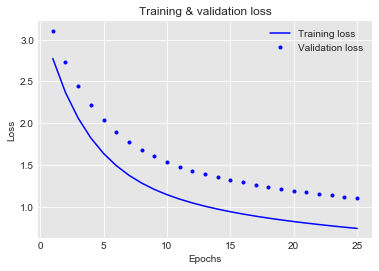

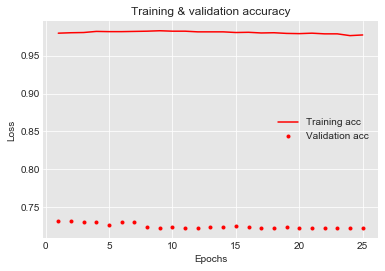

In [134]:
results_train = model.evaluate(x_train, y_train)
results_test = model.evaluate(x_test, y_test)
mlp_accuracy = results_test[1]
print(results_train)
print(results_test)
val_dict = history.history

loss_values = val_dict['loss']
val_loss_values = val_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'b.', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc_values = val_dict['acc'] 
val_acc_values = val_dict['val_acc']
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
# serialize model to JSON
model_json = model.to_json()
with open("mlp_adam_3_50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("mlp_adam_3_50.h5")
print("Saved model to disk")

Saved model to disk


### Model - SGD

In [ ]:
model = Sequential()
model.add(Dense(150, input_dim=len(vectorizer.get_feature_names()), activation=activation))
model.add(Dropout(0.3))
# model.add(Dense(150, activation=activation))
# model.add(Dropout(0.3))
model.add(Dense(1, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
model.summary()

In [ ]:
#clear logs first
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, validation_data=[x_test, y_test], callbacks=[tbcallback])

### Metrics

In [ ]:
results_train = model.evaluate(x_train, y_train)
results_test = model.evaluate(x_test, y_test)
mlp_accuracy = results_test[1]
print(results_train)
print(results_test)

plot_loss('mlp_sgd_loss.pkl')
plot_accuracy('mlp_sgd_loss.pkl')

# Convolutional Neural Net

# Classifier Performance Comparison

In [227]:
#dataframe with all metrics
data = {'Algorithm': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Gradient Boosting',
                 'AdaBoost', 'Support Vector Machines', 'Multilayer Perceptron'], 
        'Accuracy': [nb_accuracy, log_accuracy, forest_accuracy, gb_accuracy, ada_accuracy, svm_accuracy,
                    mlp_accuracy]}
metrics_df = pd.DataFrame.from_dict(data)
metrics_df

In [ ]:
metrics_df.to_csv('metrics_df.csv')

In [ ]:
#roc curve with all classifiers 
# https://stats.stackexchange.com/questions/212720/roc-curves-for-different-classifiers

# Storing models in .pickle files

In [ ]:
joblib.dump(nb, 'nb.pkl')
joblib.dump(logreg, 'log.pkl') 
joblib.dump(forest, 'forest.pkl')
joblib.dump(gradboost, 'gradboost.pkl') 
joblib.dump(adaboost, 'adaboost.pkl') 
joblib.dump(svm, 'svm.pkl') 

# Next Steps/Notes:
* Add more annotated tweets 